In [170]:
import numpy as np
import matplotlib.pyplot as plt

In [1]:
def getNeighborsAM(i, AM):
    indices = np.where(AM[i] != 0)
    return [[index, int(value)] for index, value in zip(indices[0], AM[i][indices])]

def createAM(size, edges:list):
    AM = np.zeros((size,size))
    for edge in edges:
        source, dest, weight = edge
        AM[source, dest] = weight
        AM[dest, source] = weight
    return AM

def getNeighborsAL(i, AL:dict):
    return AL[i]

def createAL(size, edges:list):
    AL = {index:[] for index in range(size)}
    for edge in edges:
        source, dest, weight = edge
        AL[source].append([dest, weight])
        AL[dest].append([source, weight])
    return AL

def getNeighborsEL(i, EL:list):
    neighbors = []
    for edge in EL:
        source, dest, weight = edge
        if(source == i):
            neighbors.append([dest, weight])
    return neighbors

def createEL(size, edges:list):
    return edges

In [188]:
getNeighbors = getNeighborsEL
createRep = createEL

Epoch 0, Loss: 1.1752118939043825
Epoch 10, Loss: 0.5839296828464212
Epoch 20, Loss: 0.3131700151622101
Epoch 30, Loss: 0.17453775305907385
Epoch 40, Loss: 0.0993157896417112
Epoch 50, Loss: 0.0572682679985146
Epoch 60, Loss: 0.03335979785002473
Epoch 70, Loss: 0.01960485105736598
Epoch 80, Loss: 0.01161595608229308
Epoch 90, Loss: 0.006936362541376156


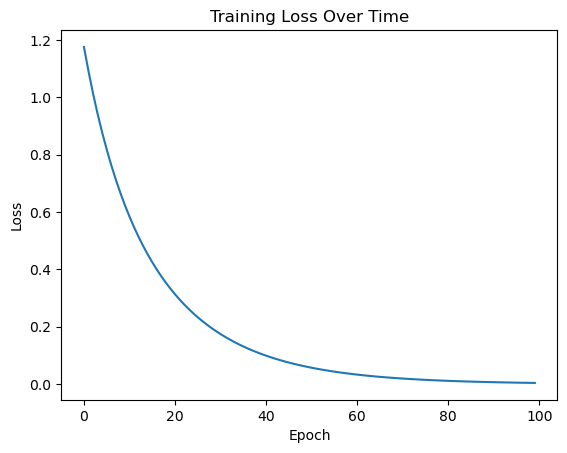

IndexError: list index out of range

In [ ]:
class Value:
    def __init__(self, data, grad=0.0):
        self.data = data  
        self.grad = grad 

class GNNLayer:
    def __init__(self, input_size):
        self.input_size = input_size
        self.weights = [Value(np.random.rand()) for _ in range(input_size)] 
        self.biases = [Value(np.random.rand()) for _ in range(input_size)]  

    def forward(self, x, nodes):
        self.input_values = x
        output = []
        
        for i in range(len(x)):
            neighbors = sum(weight * x[neighbor].data for neighbor, weight in getNeighbors(i, nodes))
            combined = neighbors * self.weights[i].data + self.biases[i].data
            output.append(Value(combined))
        
        return output

    def backward(self, target_output):
        current_output = np.array([node.data for node in self.forward(self.input_values, nodes)])
        loss = np.mean((target_output - current_output) ** 2)
        
        for i in range(self.input_size):
            grad_weight = -2 * (target_output[i] - current_output[i]) * self.input_values[i].data
            self.weights[i].grad = grad_weight
            grad_bias = -2 * (target_output[i] - current_output[i])
            self.biases[i].grad = grad_bias
        
        learning_rate = 0.01
        for i in range(self.input_size):
            self.weights[i].data -= learning_rate * self.weights[i].grad
            self.biases[i].data -= learning_rate * self.biases[i].grad
        
        return Value(loss)

def draw_gnn_graph(output):
    plt.figure(figsize=(10, 6))
    output_values = [y.data for y in output]
    for i, value in enumerate(output_values):
        plt.scatter(i, value, label=f"Nucleotide {i}")
    plt.xlabel("Nucleotide Index")
    plt.ylabel("Likelihood")
    plt.legend()
    plt.show()

def train_gnn(layer, x, adjacency_matrix, target_output, epochs=100):
    loss_values = []
    for epoch in range(epochs):
        output = layer.forward(x, adjacency_matrix)
        loss = layer.backward(target_output)

        loss_values.append(loss.data)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.data}")

    plt.plot(loss_values)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.show()

def predict_motif(output):
    nucleotide_labels = ['A', 'T', 'G', 'C']
    motif_prediction = []

    for node in output:
        most_likely_index = int(np.floor(node.data*4))
        if most_likely_index>=4:
            most_likely_index=3
        motif_prediction.append(nucleotide_labels[most_likely_index])
    
    return motif_prediction

number_of_nodes = 10
x = [Value(np.random.rand()) for _ in range(number_of_nodes)]
edges = []
num_edges = 12
while len(edges) < num_edges:
    source, dest = np.random.randint(0, number_of_nodes, size=2)
    if source != dest:
        source, dest = min(source, dest), max(source, dest)
        if (source, dest) not in [(min(e[0], e[1]), max(e[0], e[1])) for e in edges]:
            weight = np.random.randint(0, 3)
            edges.append((source, dest, weight))
nodes = createRep(number_of_nodes, edges)
target_output = np.random.rand(number_of_nodes)

layer = GNNLayer(input_size=number_of_nodes)
train_gnn(layer, x, nodes, target_output)

output = layer.forward(x, nodes)
motif_prediction = predict_motif(output)
print("Predicted Motif:", motif_prediction)

draw_gnn_graph(output)